# Exercise 1

## Part A

In [1]:
import numpy as np
import pandas as pd

In [8]:
train_file_path = 'faces/train.txt'
test_file_path = 'faces/test.txt'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

print("Train Data:")
print(train_data.head())

print("\nTest Data:")
print(test_data.head())

Train Data:
   ./faces/images/person01_63.png 1
0  ./faces/images/person01_14.png 1
1  ./faces/images/person01_09.png 1
2  ./faces/images/person01_05.png 1
3  ./faces/images/person01_01.png 1
4  ./faces/images/person01_53.png 1

Test Data:
   ./faces/images/person01_23.png 1
0  ./faces/images/person01_29.png 1
1  ./faces/images/person01_64.png 1
2  ./faces/images/person01_46.png 1
3  ./faces/images/person01_15.png 1
4  ./faces/images/person01_37.png 1


## Part B

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

Train data shape: (540, 2500)


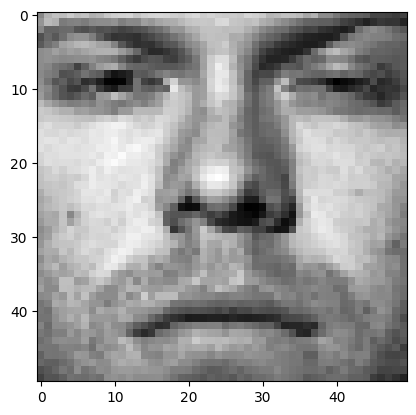

In [20]:
train_labels, train_data = [], []

with open('faces/train.txt', 'r') as f:
    for line in f:
        image_path = line.strip().split()[0]  # Extract image path
        im = Image.open(image_path).convert('L')  # Open the image and convert to grayscale ('L')
        im = np.array(im)
        train_data.append(im.reshape(2500))
        
        train_labels.append(int(line.strip().split()[1]))

# Convert to numpy arrays
train_data = np.array(train_data, dtype=float)
train_labels = np.array(train_labels, dtype=int)

print("Train data shape:", train_data.shape)

plt.imshow(train_data[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.show()

## Part C

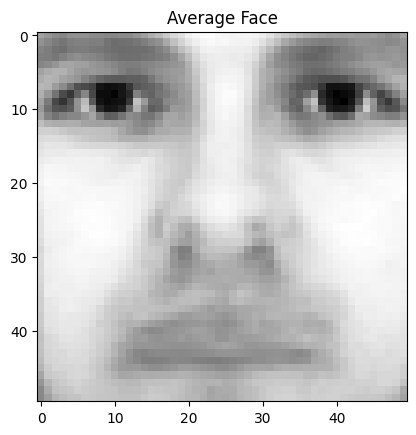

In [22]:
average_face = np.mean(train_data, axis=0)

# Reshape the average face back to 50x50 for visualization
average_face_reshaped = average_face.reshape(50, 50)

plt.imshow(average_face_reshaped, cmap=cm.Greys_r)
plt.title("Average Face")
plt.show()

## Part D

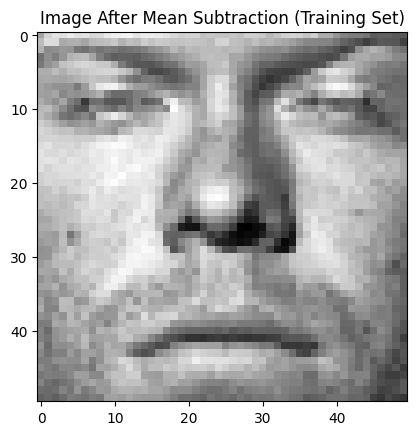

In [24]:
# Subtract the average face μ from every row in X (mean subtraction)
train_data_mean_subtracted = train_data - average_face

# Display one image from the training set after mean subtraction
plt.imshow(train_data_mean_subtracted[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title("Image After Mean Subtraction (Training Set)")
plt.show()

Test data shape: (100, 2500)


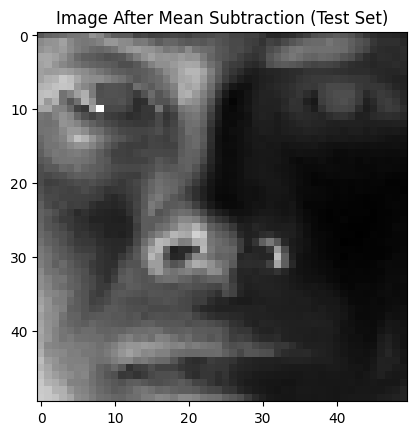

In [26]:
test_labels, test_data = [], []

# Load and process the test data
with open('faces/test.txt', 'r') as f:
    for line in f:
        image_path = line.strip().split()[0]
        im = Image.open(image_path).convert('L') 
        im = np.array(im)
        test_data.append(im.reshape(2500))
        
        test_labels.append(int(line.strip().split()[1]))

test_data = np.array(test_data, dtype=float)
test_labels = np.array(test_labels, dtype=int)
print("Test data shape:", test_data.shape)

# Subtract the precomputed average face μ from every row in the test set
test_data_mean_subtracted = test_data - average_face

plt.imshow(test_data_mean_subtracted[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title("Image After Mean Subtraction (Test Set)")
plt.show()

## Part E

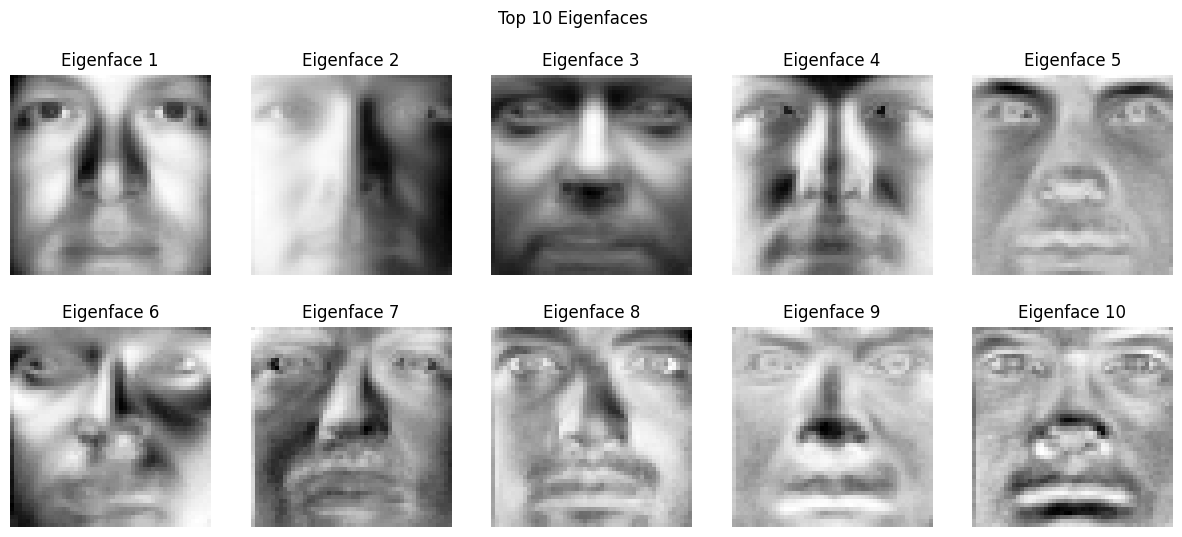

In [31]:
# Compute the covariance matrix X^T X
cov_matrix = np.dot(train_data_mean_subtracted.T, train_data_mean_subtracted)

# Perform eigendecomposition to get the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by corresponding eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# convert the eigenvectors to real numbers
eigenvectors = np.real(eigenvectors)

# Extract the top 10 eigenvectors
top_10_eigenfaces = eigenvectors[:, :10]

# Display the first 10 eigenfaces as 10 grayscale images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.ravel()

for i in range(10):
    eigenface = top_10_eigenfaces[:, i].reshape(50, 50)  # Reshape to 50x50 image for better visualization
    axs[i].imshow(eigenface, cmap=cm.Greys_r)
    axs[i].set_title(f"Eigenface {i+1}")
    axs[i].axis('off')

plt.suptitle("Top 10 Eigenfaces")
plt.show()

## Part F

In [34]:
def compute_feature_matrix(X, eigenvectors, r):
    top_r_eigenvectors = eigenvectors[:, :r]
    
    # Compute the feature matrix F by multiplying X with the top r eigenvectors
    F = np.dot(X, top_r_eigenvectors)
    return F

r = 10
F_train = compute_feature_matrix(train_data_mean_subtracted, eigenvectors, r)

F_test = compute_feature_matrix(test_data_mean_subtracted, eigenvectors, r)

print("F_train shape:", F_train.shape)
print("F_test shape:", F_test.shape)

F_train shape: (540, 10)
F_test shape: (100, 10)


## Part G

accuracy for r = 10: 80.00%


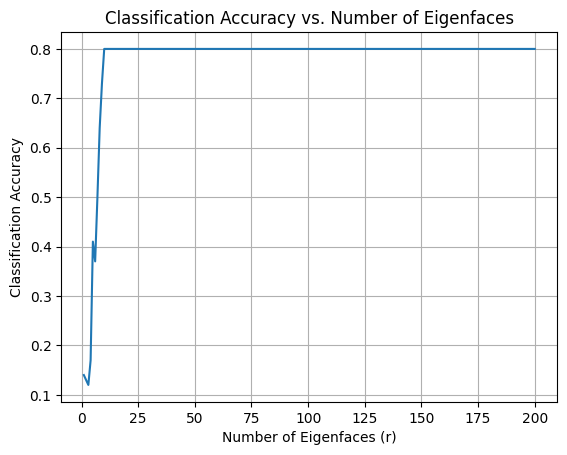

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

r_values = np.arange(1, 201)
accuracies = []

for r in r_values:
    F_train_r = F_train[:, :r]
    F_test_r = F_test[:, :r]

    clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    clf.fit(F_train_r, train_labels)

    test_predictions = clf.predict(F_test_r)

    accuracy = accuracy_score(test_labels, test_predictions)
    accuracies.append(accuracy)

    if r == 10:
        print(f"accuracy for r = 10: {accuracy * 100:.2f}%")

plt.plot(r_values, accuracies)
plt.xlabel('Number of Eigenfaces (r)')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy vs. Number of Eigenfaces')
plt.grid(True)
plt.show()

## Part H

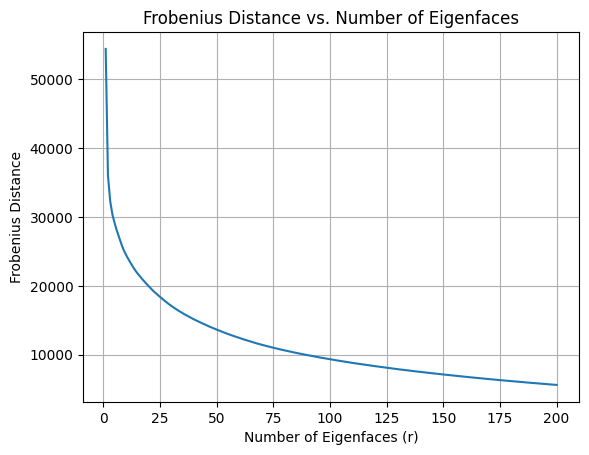

In [45]:
def compute_frobenius_distance(X, X_approx):
    difference = X - X_approx
    frobenius_dist = np.sqrt(np.trace(np.dot(difference.T, difference)))
    return frobenius_dist

r_values = np.arange(1, 201)
frobenius_distances = []

for r in r_values:
    # Compute the low-rank approximation X' using the top r eigenvectors
    top_r_eigenvectors = eigenvectors[:, :r]
    X_approx = np.dot(np.dot(train_data_mean_subtracted, top_r_eigenvectors), top_r_eigenvectors.T)

    # Compute the Frobenius distance between X and X'
    frobenius_dist = compute_frobenius_distance(train_data_mean_subtracted, X_approx)
    frobenius_distances.append(frobenius_dist)

plt.plot(r_values, frobenius_distances)
plt.xlabel('Number of Eigenfaces (r)')
plt.ylabel('Frobenius Distance')
plt.title('Frobenius Distance vs. Number of Eigenfaces')
plt.grid(True)
plt.show()

# Question 2

## Part A

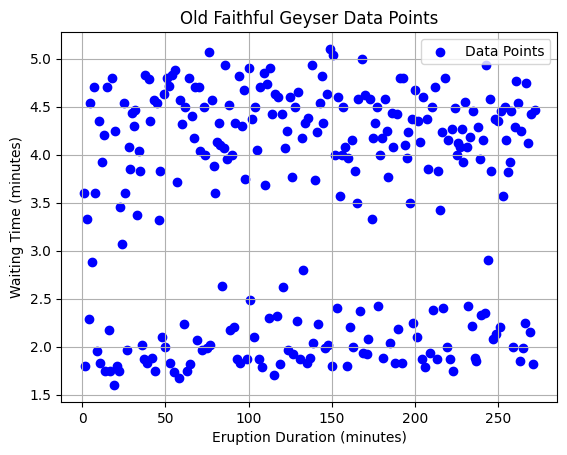

In [54]:
data_file_path = 'faithful.csv'
faithful_data = pd.read_csv(data_file_path)

x = faithful_data.iloc[:, 0]
y = faithful_data.iloc[:, 1]

plt.scatter(x, y, c='blue', label="Data Points")
plt.xlabel('Eruption Duration (minutes)')
plt.ylabel('Waiting Time (minutes)')
plt.title('Old Faithful Geyser Data Points')
plt.grid(True)
plt.legend()
plt.show()

## Part B

In [73]:
import numpy as np

def gaussian_pdf(X, mu, sigma):
    n, d = X.shape
    sigma_det = np.linalg.det(sigma)
    sigma += np.eye(d) * 1e-6
    sigma_inv = np.linalg.inv(sigma)
    norm_factor = 1.0 / (np.sqrt((2 * np.pi) ** d * sigma_det))
    diff = X - mu
    exponent = np.einsum('ij,jk,ik->i', diff, sigma_inv, diff)
    pdf_vals = norm_factor * np.exp(-0.5 * exponent)
    return pdf_vals

def posterior_probabilities(X, mu, sigma, pi, K=2):
    n, d = X.shape
    gamma = np.zeros((n, K))
    for k in range(K):
        likelihood = gaussian_pdf(X, mu[k], sigma[k])
        prior = pi[k]
        gamma[:, k] = likelihood * prior
    gamma_sum = np.sum(gamma, axis=1, keepdims=True)
    gamma_sum[gamma_sum == 0] = 1e-6
    gamma = gamma / gamma_sum
    return gamma

def log_likelihood(X, mu, sigma, pi):
    n, K = X.shape[0], mu.shape[0]
    ll = 0
    for k in range(K):
        sigma[k] += np.eye(X.shape[1]) * 1e-6
        ll += pi[k] * gaussian_pdf(X, mu[k], sigma[k])
    return np.log(ll).sum()

## Part C

In [74]:
def m_step(X, gamma):
    n, d = X.shape
    K = gamma.shape[1]
    
    mu = np.zeros((K, d))
    sigma = np.zeros((K, d, d))
    phi = np.zeros(K)
    
    for k in range(K):
        
        N_k = np.sum(gamma[:, k])
        mu[k] = np.sum(gamma[:, k, np.newaxis] * X, axis=0) / N_k
        diff = X - mu[k]
        sigma[k] = np.dot((gamma[:, k, np.newaxis] * diff).T, diff) / N_k
        phi[k] = N_k / n
    
    return mu, sigma, phi

## Part D

In [75]:
# Initialize parameters for a bimodal GMM
def initialize_parameters(X):
    n, d = X.shape
    mu = np.array([X[np.random.choice(n)], X[np.random.choice(n)]]) 
    sigma = np.array([np.eye(d), np.eye(d)])
    pi = np.array([0.5, 0.5])
    return mu, sigma, pi

def em_algorithm(X, K=2, max_iter=100, tol=1e-3):
    n, d = X.shape
    
    mu, sigma, phi = initialize_parameters(X)
    log_likelihoods = []
    mu_history = [mu.copy()]
    
    for iteration in range(max_iter):
        gamma = posterior_probabilities(X, mu, sigma, phi, K)
        
        mu, sigma, phi = m_step(X, gamma)
        
        mu_history.append(mu.copy())
        
        ll = log_likelihood(X, mu, sigma, phi)
        log_likelihoods.append(ll)
    
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged at iteration {iteration}")
            break
    
    return mu_history, mu, sigma, phi

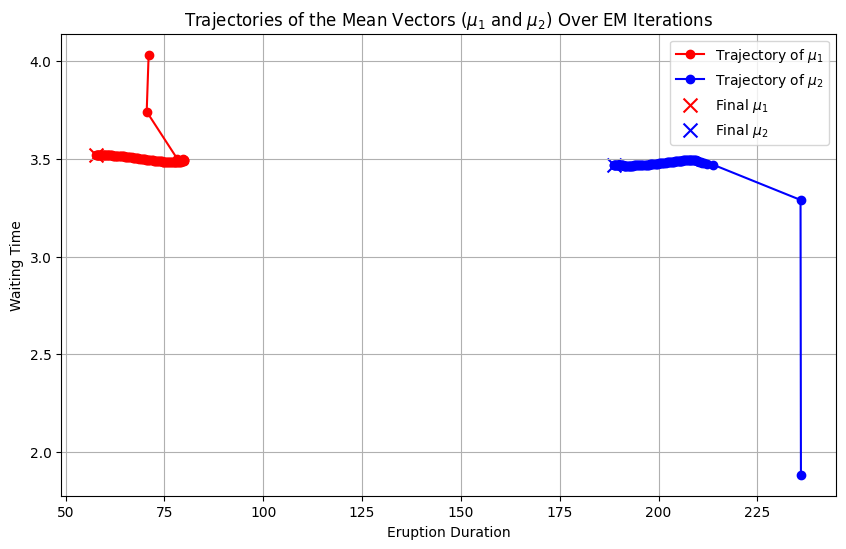

In [76]:
X = faithful_data.values 
mu_history, final_mu, final_sigma, final_phi = em_algorithm(X)

mu_history = np.array(mu_history)
plt.figure(figsize=(10, 6))

plt.plot(mu_history[:, 0, 0], mu_history[:, 0, 1], marker='o', label='Trajectory of $\\mu_1$', c='red')
plt.plot(mu_history[:, 1, 0], mu_history[:, 1, 1], marker='o', label='Trajectory of $\\mu_2$', c='blue')

plt.scatter(final_mu[0, 0], final_mu[0, 1], c='red', marker='x', s=100, label='Final $\\mu_1$')
plt.scatter(final_mu[1, 0], final_mu[1, 1], c='blue', marker='x', s=100, label='Final $\\mu_2$')

plt.title("Trajectories of the Mean Vectors ($\\mu_1$ and $\\mu_2$) Over EM Iterations")
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting Time')
plt.legend()
plt.grid(True)
plt.show()

## Part E

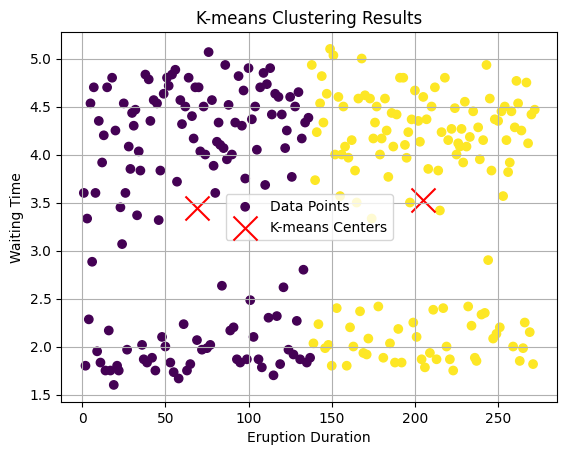

In [82]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Run K-means with K=2
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

kmeans_centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', marker='o', label='Data Points')
plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], s=300, c='red', marker='x', label='K-means Centers')
plt.title('K-means Clustering Results')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting Time')
plt.legend()
plt.grid(True)
plt.show()

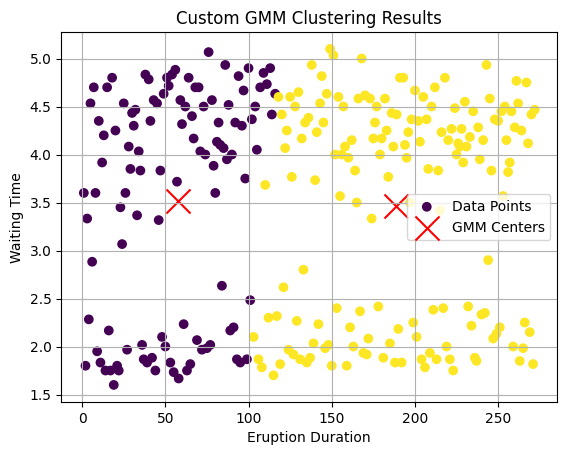

In [83]:
def plot_custom_gmm_clusters(X, mu, gamma):
    cluster_labels = np.argmax(gamma, axis=1)
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', marker='o', label='Data Points')
    plt.scatter(mu[:, 0], mu[:, 1], s=300, c='red', marker='x', label='GMM Centers')
    plt.title('Custom GMM Clustering Results')
    plt.xlabel('Eruption Duration')
    plt.ylabel('Waiting Time')
    plt.legend()
    plt.grid(True)
    plt.show()
gamma = posterior_probabilities(X, final_mu, final_sigma, final_phi)
plot_custom_gmm_clusters(X, final_mu, gamma)